In [91]:
!pip install xgboost
!pip install imblearn



In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler,label_binarize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import  classification_report, confusion_matrix, accuracy_score, f1_score,precision_score, recall_score, roc_auc_score, average_precision_score,roc_curve, precision_recall_curve, hamming_loss,auc
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold

In [93]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [94]:
data=pd.read_csv("/content/drive/MyDrive/Dataset_SRIP/UNSW_2018_IoT_Botnet_Full5pc_1.csv")
data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/UNSW_2018_IoT_Botnet_Full5pc_2.csv")])
data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/UNSW_2018_IoT_Botnet_Full5pc_3.csv")])
data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/UNSW_2018_IoT_Botnet_Full5pc_4.csv")])
data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/final_1.csv")])
data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/final_2.csv")])
data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/final_3.csv")])
data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/final_4.csv")])
data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/final_5.csv")])

/tmp/ipython-input-3093493103.py:1: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv("/content/drive/MyDrive/Dataset_SRIP/UNSW_2018_IoT_Botnet_Full5pc_1.csv")
/tmp/ipython-input-3093493103.py:2: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/UNSW_2018_IoT_Botnet_Full5pc_2.csv")])
/tmp/ipython-input-3093493103.py:3: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/UNSW_2018_IoT_Botnet_Full5pc_3.csv")])
/tmp/ipython-input-3093493103.py:4: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.concat([data,pd.read_csv(r"/content/drive/MyDrive/Dataset_SRIP/UNSW_2018_IoT_Botnet_Full5pc_4.csv")])


In [95]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3679172 entries, 0 to 431
Data columns (total 46 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   pkSeqID                           int64  
 1   stime                             float64
 2   flgs                              object 
 3   flgs_number                       int64  
 4   proto                             object 
 5   proto_number                      int64  
 6   saddr                             object 
 7   sport                             object 
 8   daddr                             object 
 9   dport                             object 
 10  pkts                              int64  
 11  bytes                             int64  
 12  state                             object 
 13  state_number                      int64  
 14  ltime                             float64
 15  seq                               int64  
 16  dur                               float64
 17

In [96]:
data.columns

Index(['pkSeqID', 'stime', 'flgs', 'flgs_number', 'proto', 'proto_number',
       'saddr', 'sport', 'daddr', 'dport', 'pkts', 'bytes', 'state',
       'state_number', 'ltime', 'seq', 'dur', 'mean', 'stddev', 'sum', 'min',
       'max', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'srate', 'drate',
       'TnBPSrcIP', 'TnBPDstIP', 'TnP_PSrcIP', 'TnP_PDstIP', 'TnP_PerProto',
       'TnP_Per_Dport', 'AR_P_Proto_P_SrcIP', 'AR_P_Proto_P_DstIP',
       'N_IN_Conn_P_DstIP', 'N_IN_Conn_P_SrcIP', 'AR_P_Proto_P_Sport',
       'AR_P_Proto_P_Dport', 'Pkts_P_State_P_Protocol_P_DestIP',
       'Pkts_P_State_P_Protocol_P_SrcIP', 'attack', 'category', 'subcategory'],
      dtype='object')

In [97]:
data=data.drop_duplicates()

In [98]:
#dropping irrelevant features
data=data.drop(columns=["pkSeqID","stime","flgs","proto","saddr","sport","daddr","dport","state","ltime","seq"])

In [99]:
#dropping correlated columns
data=data.drop(columns=["bytes","max","spkts","sbytes","dbytes","AR_P_Proto_P_Dport","state_number","dpkts"])

In [100]:
data.isnull().sum()

,0
flgs_number,0
proto_number,0
pkts,0
dur,0
mean,0
stddev,0
sum,0
min,0
rate,0
srate,0


In [101]:
data.head()

,flgs_number,proto_number,pkts,dur,mean,stddev,sum,min,rate,srate,...,AR_P_Proto_P_SrcIP,AR_P_Proto_P_DstIP,N_IN_Conn_P_DstIP,N_IN_Conn_P_SrcIP,AR_P_Proto_P_Sport,Pkts_P_State_P_Protocol_P_DestIP,Pkts_P_State_P_Protocol_P_SrcIP,attack,category,subcategory
0,1,1,8,7.056393,0.068909,0.068909,0.137818,0.000000,0.992008,0.566862,...,1.142970,1.12704,96,75,1.133720,770,602,1,DoS,HTTP
1,1,2,2,0.000131,0.000131,0.000000,0.000131,0.000131,7633.588379,0.000000,...,0.003857,15267.20000,1,2,0.005142,2,6,1,DoS,HTTP
2,1,1,8,7.047852,0.064494,0.064494,0.128988,0.000000,0.993210,0.567549,...,1.142970,1.12704,96,75,1.135100,770,602,1,DoS,HTTP
3,1,1,8,7.047592,0.064189,0.064189,0.128378,0.000000,0.993247,0.567570,...,1.142970,1.12704,96,75,1.135140,770,602,1,DoS,HTTP
4,1,1,8,7.046841,0.063887,0.063887,0.127774,0.000000,0.993353,0.567630,...,1.142970,1.12704,96,75,1.135260,770,602,1,DoS,HTTP


In [102]:

categories_to_reduce = ['DDoS', 'DoS', 'Reconnaissance']
target_count = 30000

def reduce_samples(df, categories, target_count):
    reduced_df = pd.DataFrame()

    for category in categories:
        category_df = df[df['category'] == category]
        print(f"Original count for {category}: {len(category_df)}")

        if len(category_df) > target_count:
            category_df = category_df.sample(n=target_count, random_state=42)
            print(f"Reduced to {len(category_df)} for {category}")
        else:
            print(f"No reduction needed for {category}")

        reduced_df = pd.concat([reduced_df, category_df], ignore_index=True)

    other_df = df[~df['category'].isin(categories)]
    reduced_df = pd.concat([reduced_df, other_df], ignore_index=True)

    return reduced_df

data = reduce_samples(data, categories_to_reduce, target_count)



Original count for DDoS: 1926624
Reduced to 30000 for DDoS
Original count for DoS: 1650260
Reduced to 30000 for DoS
Original count for Reconnaissance: 91082
Reduced to 30000 for Reconnaissance


In [103]:
data['category'].value_counts()

,count
category,
DDoS,30000
DoS,30000
Reconnaissance,30000
Normal,9549
Theft,1657


In [104]:
data["attack"].value_counts()

,count
attack,
1,91657
0,9549


In [105]:
data["subcategory"].value_counts()

,count
subcategory,
UDP,33632
TCP,26327
Service_Scan,24162
Normal,9549
OS_Fingerprint,5838
Keylogging,1537
Data_Exfiltration,120
HTTP,41


In [106]:
le = LabelEncoder()
data['category'] = le.fit_transform(data['category'])
data['subcategory'] = le.fit_transform(data['subcategory'])
data.head()

,flgs_number,proto_number,pkts,dur,mean,stddev,sum,min,rate,srate,...,AR_P_Proto_P_SrcIP,AR_P_Proto_P_DstIP,N_IN_Conn_P_DstIP,N_IN_Conn_P_SrcIP,AR_P_Proto_P_Sport,Pkts_P_State_P_Protocol_P_DestIP,Pkts_P_State_P_Protocol_P_SrcIP,attack,category,subcategory
0,1,3,15,13.955115,3.982232,1.413917,11.946695,1.982758,1.003216,1.003216,...,1.074890,1.037410,100,93,1.074870,1451,1395,1,0,7
1,1,3,14,13.962423,3.987533,0.821593,11.962599,2.983338,0.931070,0.931070,...,1.055830,0.958112,100,62,1.002690,1332,914,1,0,7
2,2,1,5,12.984385,2.199934,1.563204,6.599802,0.000000,0.308062,0.308062,...,0.426398,0.426398,100,100,0.385078,360,360,1,0,6
3,1,3,8,14.194972,3.381320,0.950962,10.143960,2.036473,0.493132,0.493132,...,0.563580,0.563580,100,100,0.563580,800,800,1,0,7
4,1,1,3,0.210202,0.210202,0.000000,0.210202,0.210202,9.514658,4.757329,...,21.318300,21.318300,100,100,14.272000,114,114,1,0,6


In [107]:
Y = data[['attack','category','subcategory']]
X= data.drop(['attack','category','subcategory'],axis=1)

In [108]:
X.head()

,flgs_number,proto_number,pkts,dur,mean,stddev,sum,min,rate,srate,...,TnP_PDstIP,TnP_PerProto,TnP_Per_Dport,AR_P_Proto_P_SrcIP,AR_P_Proto_P_DstIP,N_IN_Conn_P_DstIP,N_IN_Conn_P_SrcIP,AR_P_Proto_P_Sport,Pkts_P_State_P_Protocol_P_DestIP,Pkts_P_State_P_Protocol_P_SrcIP
0,1,3,15,13.955115,3.982232,1.413917,11.946695,1.982758,1.003216,1.003216,...,1451,1451,1451,1.074890,1.037410,100,93,1.074870,1451,1395
1,1,3,14,13.962423,3.987533,0.821593,11.962599,2.983338,0.931070,0.931070,...,1332,1332,1332,1.055830,0.958112,100,62,1.002690,1332,914
2,2,1,5,12.984385,2.199934,1.563204,6.599802,0.000000,0.308062,0.308062,...,556,556,556,0.426398,0.426398,100,100,0.385078,360,360
3,1,3,8,14.194972,3.381320,0.950962,10.143960,2.036473,0.493132,0.493132,...,800,800,800,0.563580,0.563580,100,100,0.563580,800,800
4,1,1,3,0.210202,0.210202,0.000000,0.210202,0.210202,9.514658,4.757329,...,176,176,176,21.318300,21.318300,100,100,14.272000,114,114


In [109]:
#mutual information
mi_attack = mutual_info_classif(X, Y["attack"])
mi_subcat = mutual_info_classif(X, Y["subcategory"])
mi_cat    = mutual_info_classif(X, Y["category"])
mi_avg = (mi_attack + mi_subcat + mi_cat) / 3

df_mi = pd.DataFrame({
    'feature': X.columns.tolist(),
    'MI_attack': mi_attack,
    'MI_subcategory': mi_subcat,
    'MI_category': mi_cat,
    'MI_average': mi_avg
})

df_mi_sorted = df_mi.sort_values(by='MI_average', ascending=False)
top_features = df_mi_sorted.head(20)['feature'].tolist()
X = X[top_features]


In [110]:
X.head()

,AR_P_Proto_P_DstIP,AR_P_Proto_P_SrcIP,AR_P_Proto_P_Sport,TnBPDstIP,TnBPSrcIP,dur,rate,TnP_Per_Dport,TnP_PerProto,TnP_PDstIP,srate,Pkts_P_State_P_Protocol_P_DestIP,Pkts_P_State_P_Protocol_P_SrcIP,TnP_PSrcIP,sum,mean,pkts,min,stddev,N_IN_Conn_P_DstIP
0,1.037410,1.074890,1.074870,87060,83700,13.955115,1.003216,1451,1451,1451,1.003216,1451,1395,1395,11.946695,3.982232,15,1.982758,1.413917,100
1,0.958112,1.055830,1.002690,79920,54840,13.962423,0.931070,1332,1332,1332,0.931070,1332,914,914,11.962599,3.987533,14,2.983338,0.821593,100
2,0.426398,0.426398,0.385078,80360,80360,12.984385,0.308062,556,556,556,0.308062,360,360,556,6.599802,2.199934,5,0.000000,1.563204,100
3,0.563580,0.563580,0.563580,48000,48000,14.194972,0.493132,800,800,800,0.493132,800,800,800,10.143960,3.381320,8,2.036473,0.950962,100
4,21.318300,21.318300,14.272000,19960,19960,0.210202,9.514658,176,176,176,4.757329,114,114,176,0.210202,0.210202,3,0.210202,0.000000,100


In [111]:
#tree based feature selection
model = XGBClassifier(tree_method='hist', n_jobs=-1)
model.fit(X, Y["attack"])


model2 = XGBClassifier(tree_method='hist', n_jobs=-1)
model2.fit(X, Y["category"])


importances = model.feature_importances_
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

top_features = importance_df['feature'].head(10)



importances = model2.feature_importances_
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

top_features2 = importance_df['feature'].head(10)


combined_features = set(top_features) | set(top_features2)
X = X[list(combined_features)]

In [112]:
X.head()

,srate,TnP_PSrcIP,TnP_PerProto,dur,N_IN_Conn_P_DstIP,AR_P_Proto_P_DstIP,Pkts_P_State_P_Protocol_P_SrcIP,rate,TnBPDstIP,Pkts_P_State_P_Protocol_P_DestIP,TnP_Per_Dport,sum,AR_P_Proto_P_SrcIP,stddev,min,AR_P_Proto_P_Sport
0,1.003216,1395,1451,13.955115,100,1.037410,1395,1.003216,87060,1451,1451,11.946695,1.074890,1.413917,1.982758,1.074870
1,0.931070,914,1332,13.962423,100,0.958112,914,0.931070,79920,1332,1332,11.962599,1.055830,0.821593,2.983338,1.002690
2,0.308062,556,556,12.984385,100,0.426398,360,0.308062,80360,360,556,6.599802,0.426398,1.563204,0.000000,0.385078
3,0.493132,800,800,14.194972,100,0.563580,800,0.493132,48000,800,800,10.143960,0.563580,0.950962,2.036473,0.563580
4,4.757329,176,176,0.210202,100,21.318300,114,9.514658,19960,114,176,0.210202,21.318300,0.000000,0.210202,14.272000


In [113]:
sc = StandardScaler()
X = sc.fit_transform(X)

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)


In [115]:
# Smote Oversampling
y_all = y_train[['attack', 'category', 'subcategory']].reset_index(drop=True)

sm = SMOTE(k_neighbors=3, random_state=42)
X_resampled, y_attack_resampled = sm.fit_resample(X_train, y_all['attack'])

n_original = len(X_train)
n_total = len(X_resampled)
n_synthetic = n_total - n_original

normal_cat = le.transform(["Normal"])[0]
normal_subcat = le.transform(["Normal"])[0]

y_category_resampled = pd.concat([
    y_all['category'],
    pd.Series([normal_cat] * n_synthetic)
], ignore_index=True)

y_subcategory_resampled = pd.concat([
    y_all['subcategory'],
    pd.Series([normal_subcat] * n_synthetic)
], ignore_index=True)

y_train_resampled = pd.DataFrame({
    "attack": y_attack_resampled,
    "category": y_category_resampled,
    "subcategory": y_subcategory_resampled
})

X_train = X_resampled
y_train = y_train_resampled



In [116]:
class RandomForest:
    def __init__(self,max_depth):
        self.rfc_attack = RandomForestClassifier(max_depth=max_depth)
        self.rfc_category = RandomForestClassifier(max_depth=max_depth)
        self.rfc_subcategory = RandomForestClassifier(max_depth=max_depth)

    def fit(self,X_train,y_train):
        self.rfc_attack.fit(X_train,y_train['attack'])

        features_category = np.concatenate((X_train,np.array(y_train['attack']).reshape(-1,1)),axis=1)
        self.rfc_category.fit(features_category,y_train['category'])

        features_subcategory = np.concatenate((features_category,np.array(y_train['category']).reshape(-1,1)),axis=1)
        self.rfc_subcategory.fit(features_subcategory,y_train['subcategory'])

    def predict(self,X_test):
        predict_attack = self.rfc_attack.predict(X_test)
        y_proba=self.rfc_attack.predict_proba(X_test)[:,1]
        test_category = np.concatenate((X_test,predict_attack.reshape(-1,1)),axis=1)
        predict_category = self.rfc_category.predict(test_category)

        test_subcategory = np.concatenate((test_category,predict_category.reshape(-1,1)),axis=1)
        predict_subcategory = self.rfc_subcategory.predict(test_subcategory)

        return pd.DataFrame({'attack':predict_attack,'category':predict_category,'subcategory':predict_subcategory,"y_proba":y_proba})

In [117]:
def display_metrics(y_true, y_pred, title, y_proba=None):
    print(f"\n--- {title} ---")

    # Classification report as table
    print("\n📋 Classification Report:")
    report = classification_report(y_true, y_pred, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    print(df_report.iloc[:-3])

    # Confusion matrix heatmap
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {title}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # Metrics
    acc = accuracy_score(y_true, y_pred)
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    ham_loss = hamming_loss(y_true, y_pred)

    print(f"\n✅ Accuracy: {acc:.4f}")
    print(f"✅ Weighted F1 Score: {f1_weighted:.4f}")
    print(f"✅ Macro F1 Score: {f1_macro:.4f}")
    print(f"✅ Macro Precision: {precision_macro:.4f}")
    print(f"✅ Macro Recall: {recall_macro:.4f}")
    print(f"❌ Hamming Loss: {ham_loss:.6f}")

    # Multi-class Precision-Recall curve
    if y_proba is not None:
        classes = np.unique(y_true)
        y_true_bin = label_binarize(y_true, classes=classes)
        plt.figure(figsize=(10, 7))
        for i, cls in enumerate(classes):
            if y_proba.ndim == 1 or y_proba.shape[1] == 1:
                raise ValueError("y_proba must be 2D array for multi-class PR curve")
            precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_proba[:, i])
            ap = average_precision_score(y_true_bin[:, i], y_proba[:, i])
            plt.plot(recall, precision, label=f"{cls} (AP={ap:.2f})")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"Multi-class Precision-Recall Curve - {title}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

**Random Forest**

In [118]:
rf = RandomForest(max_depth=3)
rf.fit(X_train,y_train)

predictions_rfc = rf.predict(X_test)




--- Attack Prediction ---

📋 Classification Report:
   precision    recall  f1-score  support
0   0.962025  0.994764  0.978121   1910.0
1   0.999453  0.995909  0.997678  18332.0


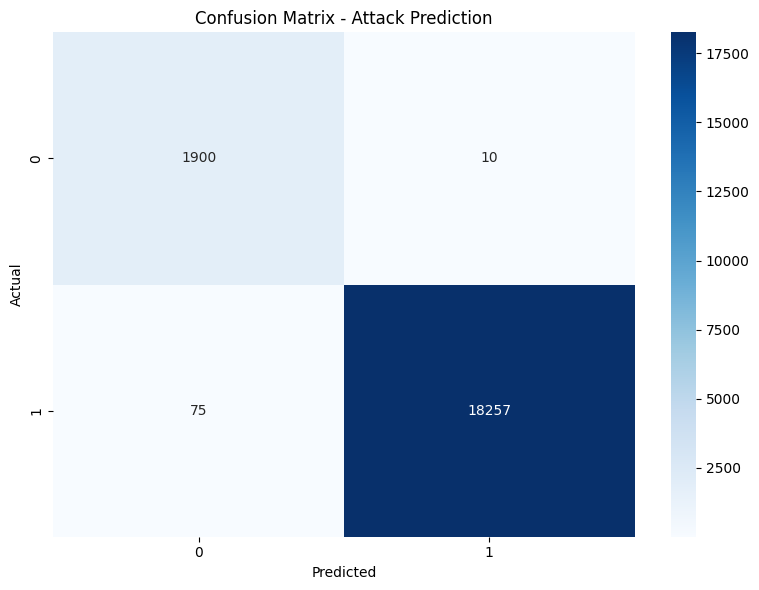


✅ Accuracy: 0.9958
✅ Weighted F1 Score: 0.9958
✅ Macro F1 Score: 0.9879
✅ Macro Precision: 0.9807
✅ Macro Recall: 0.9953
❌ Hamming Loss: 0.004199


In [119]:
display_metrics(y_test['attack'], predictions_rfc['attack'], "Attack Prediction")


--- Category Prediction ---

📋 Classification Report:
   precision    recall  f1-score  support
0   0.992993  0.850333  0.916143   6000.0
1   0.895382  0.950000  0.921883   6000.0
2   0.000000  0.000000  0.000000   1910.0
3   0.705495  0.999167  0.827034   6001.0
4   1.000000  0.722054  0.838596    331.0


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


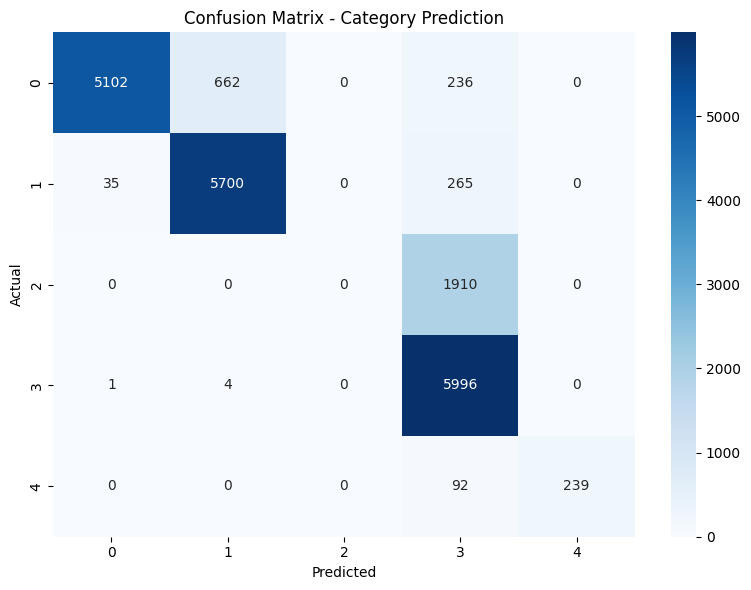


✅ Accuracy: 0.8417
✅ Weighted F1 Score: 0.8037
✅ Macro F1 Score: 0.7007
✅ Macro Precision: 0.7188
✅ Macro Recall: 0.7043
❌ Hamming Loss: 0.158334


In [120]:
display_metrics(y_test['category'], predictions_rfc['category'], "Category Prediction")


--- Subcategory Prediction ---

📋 Classification Report:
   precision    recall  f1-score  support
0   0.000000  0.000000  0.000000     24.0
1   0.000000  0.000000  0.000000      9.0
2   0.975510  0.778502  0.865942    307.0
3   0.962025  0.994764  0.978121   1910.0
4   0.000000  0.000000  0.000000   1168.0
5   0.741178  0.999586  0.851203   4833.0
6   0.958050  0.828490  0.888572   5265.0
7   0.941160  0.972643  0.956643   6726.0


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


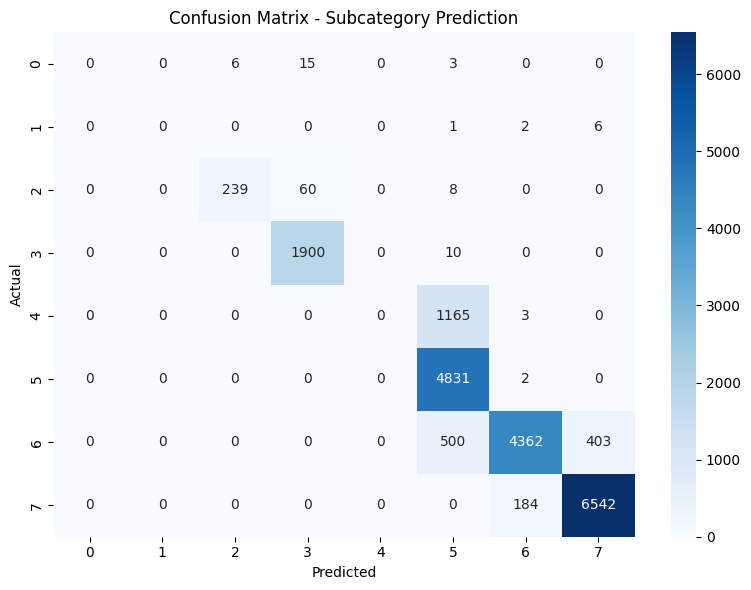


✅ Accuracy: 0.8830
✅ Weighted F1 Score: 0.8577
✅ Macro F1 Score: 0.5676
✅ Macro Precision: 0.5722
✅ Macro Recall: 0.5717
❌ Hamming Loss: 0.116984


In [121]:
display_metrics(y_test['subcategory'], predictions_rfc['subcategory'], "Subcategory Prediction")

XGB graddient boosting


In [122]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train the model
xgb_model.fit(X_train, y_train["attack"])

# Predict
y_pred_xgb = xgb_model.predict(X_test)

y_proba = xgb_model.predict_proba(X_test)[:, 1]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:00:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Attack Prediction ---

📋 Classification Report:
   precision  recall  f1-score  support
0        1.0     1.0       1.0   1910.0
1        1.0     1.0       1.0  18332.0


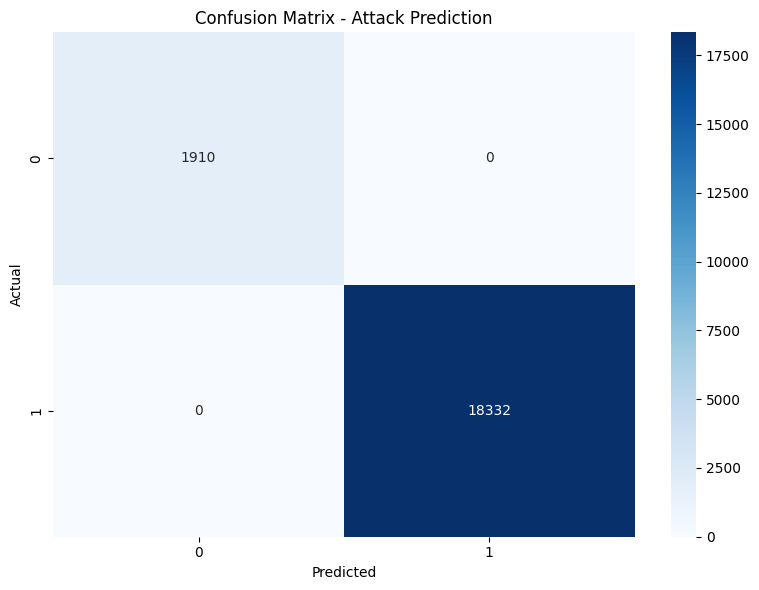


✅ Accuracy: 1.0000
✅ Weighted F1 Score: 1.0000
✅ Macro F1 Score: 1.0000
✅ Macro Precision: 1.0000
✅ Macro Recall: 1.0000
❌ Hamming Loss: 0.000000


In [123]:
display_metrics(y_test['attack'], y_pred_xgb, "Attack Prediction")

In [124]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train the model
xgb_model.fit(X_train, y_train["category"])

# Predict
y_pred_xgb = xgb_model.predict(X_test)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:00:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Category Prediction ---

📋 Classification Report:
   precision    recall  f1-score  support
0   0.999666  0.999000  0.999333   6000.0
1   0.999001  0.999833  0.999417   6000.0
2   1.000000  0.039791  0.076536   1910.0
3   0.765697  0.999833  0.867240   6001.0
4   1.000000  0.993958  0.996970    331.0


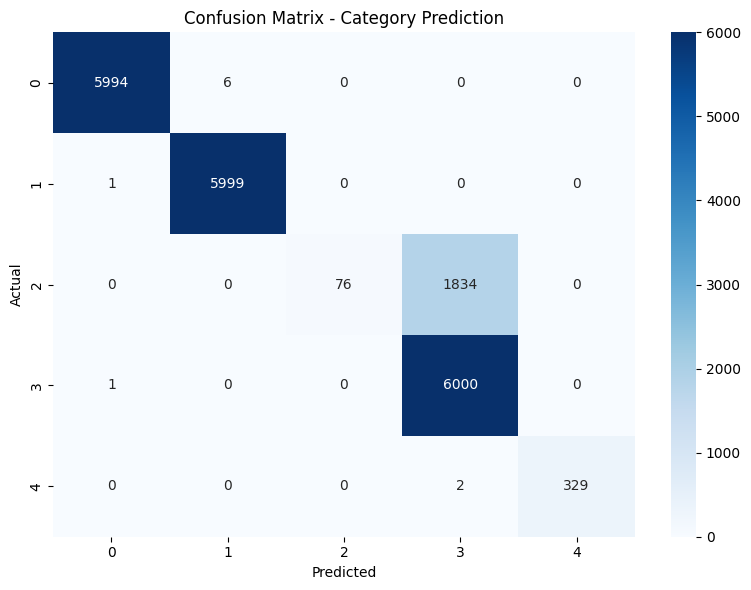


✅ Accuracy: 0.9089
✅ Weighted F1 Score: 0.8731
✅ Macro F1 Score: 0.7879
✅ Macro Precision: 0.9529
✅ Macro Recall: 0.8065
❌ Hamming Loss: 0.091098


In [125]:
display_metrics(y_test['category'], y_pred_xgb, "Category Prediction")

In [126]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train the model
xgb_model.fit(X_train, y_train["subcategory"])

# Predict
y_pred_xgb = xgb_model.predict(X_test)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:00:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Subcategory Prediction ---

📋 Classification Report:
   precision    recall  f1-score  support
0   0.708333  0.708333  0.708333     24.0
1   1.000000  0.888889  0.941176      9.0
2   0.980263  0.970684  0.975450    307.0
3   0.998432  1.000000  0.999215   1910.0
4   0.931878  0.913527  0.922611   1168.0
5   0.979201  0.983861  0.981525   4833.0
6   0.999810  1.000000  0.999905   5265.0
7   1.000000  1.000000  1.000000   6726.0


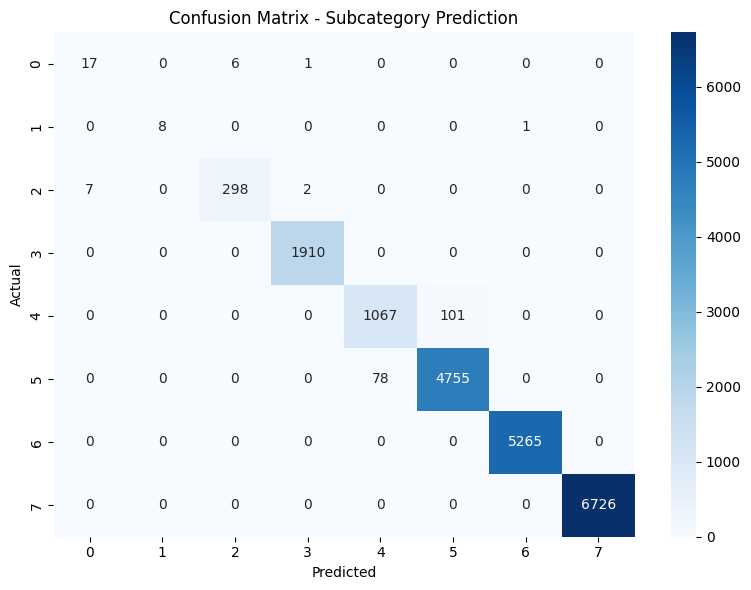


✅ Accuracy: 0.9903
✅ Weighted F1 Score: 0.9903
✅ Macro F1 Score: 0.9410
✅ Macro Precision: 0.9497
✅ Macro Recall: 0.9332
❌ Hamming Loss: 0.009683


In [127]:
display_metrics(y_test['subcategory'], y_pred_xgb, "Subcategory Prediction")

Logistic Regression


In [128]:
logreg_model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
logreg_model.fit(X_train, y_train["attack"])

# Predict
y_pred_logreg = logreg_model.predict(X_test)

y_proba = logreg_model.predict_proba(X_test)[:, 1]


--- Attack Prediction ---

📋 Classification Report:
   precision    recall  f1-score  support
0   0.982833  0.959162  0.970853   1910.0
1   0.995756  0.998254  0.997004  18332.0


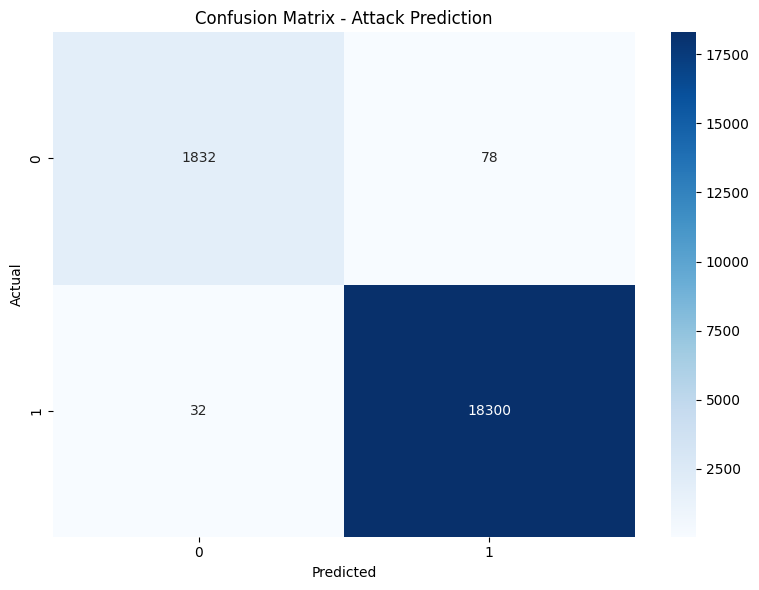


✅ Accuracy: 0.9946
✅ Weighted F1 Score: 0.9945
✅ Macro F1 Score: 0.9839
✅ Macro Precision: 0.9893
✅ Macro Recall: 0.9787
❌ Hamming Loss: 0.005434


In [129]:
display_metrics(y_test['attack'], y_pred_logreg, "Attack Prediction")


In [130]:
logreg_model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
logreg_model.fit(X_train, y_train["category"])

# Predict
y_pred_logreg = logreg_model.predict(X_test)



--- Category Prediction ---

📋 Classification Report:
   precision    recall  f1-score  support
0   0.786594  0.884000  0.832457   6000.0
1   0.868285  0.781167  0.822425   6000.0
2   0.000000  0.000000  0.000000   1910.0
3   0.694116  0.900350  0.783896   6001.0
4   1.000000  0.957704  0.978395    331.0


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


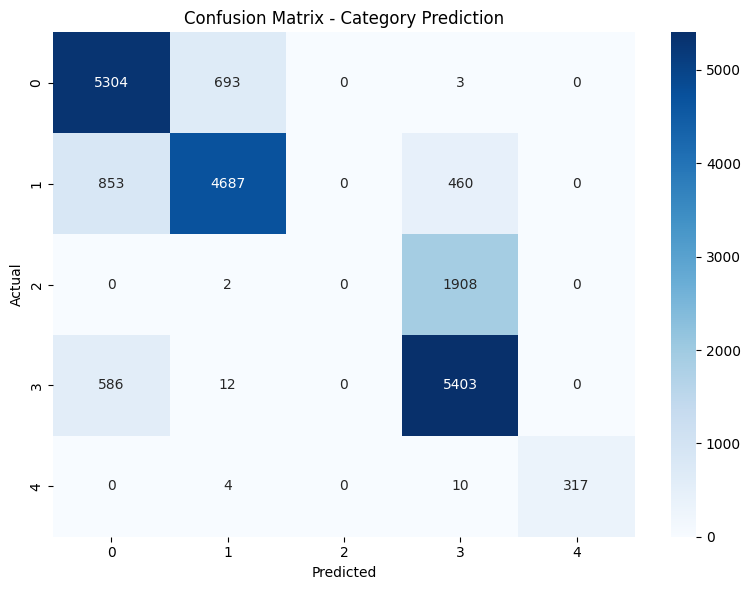


✅ Accuracy: 0.7762
✅ Weighted F1 Score: 0.7389
✅ Macro F1 Score: 0.6834
✅ Macro Precision: 0.6698
✅ Macro Recall: 0.7046
❌ Hamming Loss: 0.223842


In [131]:
display_metrics(y_test['category'], y_pred_logreg, "Category Prediction")

In [132]:
logreg_model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
logreg_model.fit(X_train, y_train["subcategory"])

# Predict
y_pred_logreg = logreg_model.predict(X_test)


--- Subcategory Prediction ---

📋 Classification Report:
   precision    recall  f1-score  support
0   0.000000  0.000000  0.000000     24.0
1   0.000000  0.000000  0.000000      9.0
2   0.931034  0.967427  0.948882    307.0
3   0.991645  0.994241  0.992941   1910.0
4   0.500000  0.000856  0.001709   1168.0
5   0.769776  0.875854  0.819396   4833.0
6   0.849878  0.860209  0.855012   5265.0
7   0.916272  0.977847  0.946059   6726.0


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


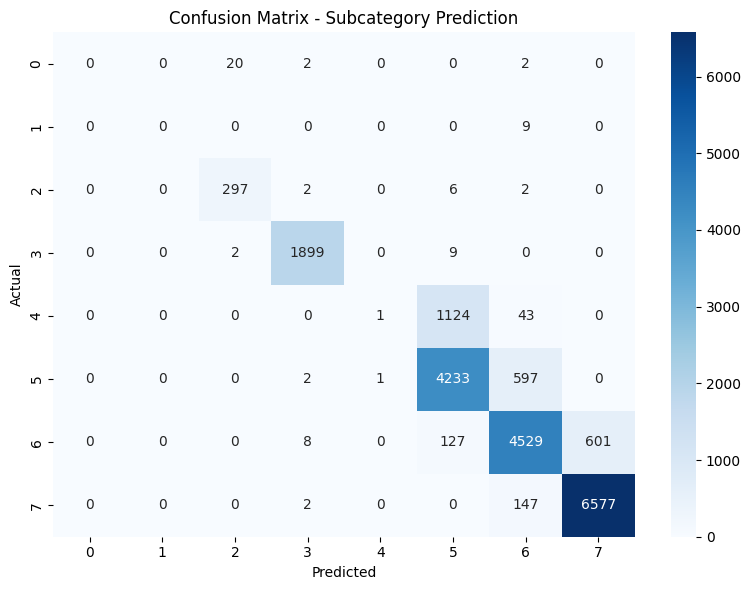


✅ Accuracy: 0.8663
✅ Weighted F1 Score: 0.8406
✅ Macro F1 Score: 0.5705
✅ Macro Precision: 0.6198
✅ Macro Recall: 0.5846
❌ Hamming Loss: 0.133682


In [133]:
display_metrics(y_test['subcategory'], y_pred_logreg, "Subcategory Prediction")

Stacked Model

In [134]:
class StackedEnsemble:
    def __init__(self, n_folds=5, random_state=42):
        self.n_folds = n_folds
        self.random_state = random_state
        self.base_learners = [
            XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=random_state),
            RandomForestClassifier(n_estimators=200, random_state=random_state)
        ]
        self.meta_learner = LogisticRegression(multi_class='multinomial', max_iter=1000)
        self.classes_ = None

    def fit(self, X, y):
        # Convert DataFrame/Series to NumPy arrays if needed
        if hasattr(X, "values"):
            X = X.values
        if hasattr(y, "values"):
            y = y.values

        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)
        n_samples = X.shape[0]
        base_preds = np.zeros((n_samples, n_classes * len(self.base_learners)))

        skf = StratifiedKFold(n_splits=self.n_folds, shuffle=True, random_state=self.random_state)

        for i, model in enumerate(self.base_learners):
            oof_preds = np.zeros((n_samples, n_classes))
            for train_idx, val_idx in skf.split(X, y):
                X_train_fold, X_val_fold = X[train_idx], X[val_idx]
                y_train_fold = y[train_idx]
                model.fit(X_train_fold, y_train_fold)
                oof_preds[val_idx, :] = model.predict_proba(X_val_fold)
            base_preds[:, i*n_classes:(i+1)*n_classes] = oof_preds
            model.fit(X, y)

        self.meta_learner.fit(base_preds, y)

    def predict_proba(self, X):
        if hasattr(X, "values"):
            X = X.values
        n_classes = len(self.classes_)
        base_preds = np.zeros((X.shape[0], n_classes * len(self.base_learners)))
        for i, model in enumerate(self.base_learners):
            base_preds[:, i*n_classes:(i+1)*n_classes] = model.predict_proba(X)
        return self.meta_learner.predict_proba(base_preds)

    def predict(self, X):
        probs = self.predict_proba(X)
        preds = np.argmax(probs, axis=1)
        return preds


In [135]:
stacked=StackedEnsemble(n_folds=5)



stacked.fit(X_train, y_train["attack"])



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:03:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:03:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:03:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:03:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:03:20] WARNING: /w


--- Attack ---

📋 Classification Report:
   precision  recall  f1-score  support
0        1.0     1.0       1.0   1910.0
1        1.0     1.0       1.0  18332.0


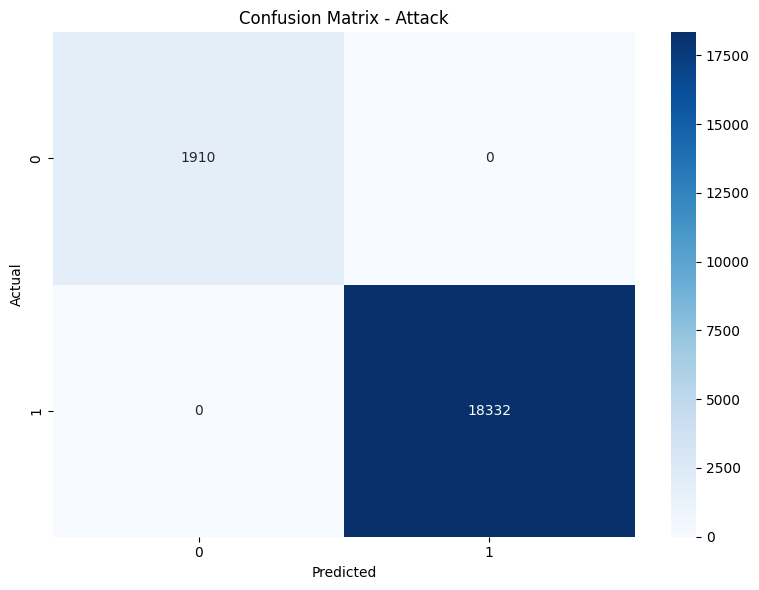


✅ Accuracy: 1.0000
✅ Weighted F1 Score: 1.0000
✅ Macro F1 Score: 1.0000
✅ Macro Precision: 1.0000
✅ Macro Recall: 1.0000
❌ Hamming Loss: 0.000000


In [136]:
y_pred_attack = stacked.predict(X_test)
display_metrics(y_test["attack"], y_pred_attack,"Attack")

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:06:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:07:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:07:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:07:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:07:23] WARNING: /w


--- category ---

📋 Classification Report:
   precision    recall  f1-score  support
0   0.999666  0.999000  0.999333   6000.0
1   0.999001  0.999833  0.999417   6000.0
2   1.000000  0.059162  0.111715   1910.0
3   0.769428  0.999833  0.869628   6001.0
4   1.000000  0.996979  0.998487    331.0


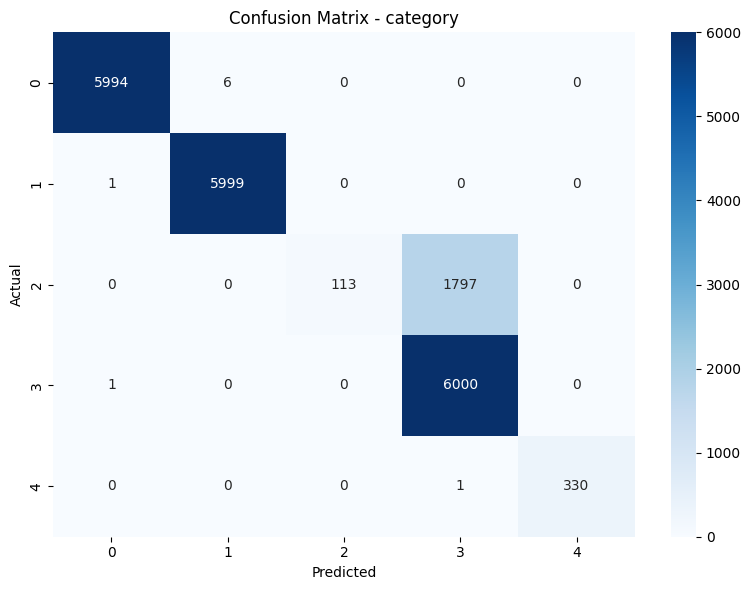


✅ Accuracy: 0.9108
✅ Weighted F1 Score: 0.8771
✅ Macro F1 Score: 0.7957
✅ Macro Precision: 0.9536
✅ Macro Recall: 0.8110
❌ Hamming Loss: 0.089220


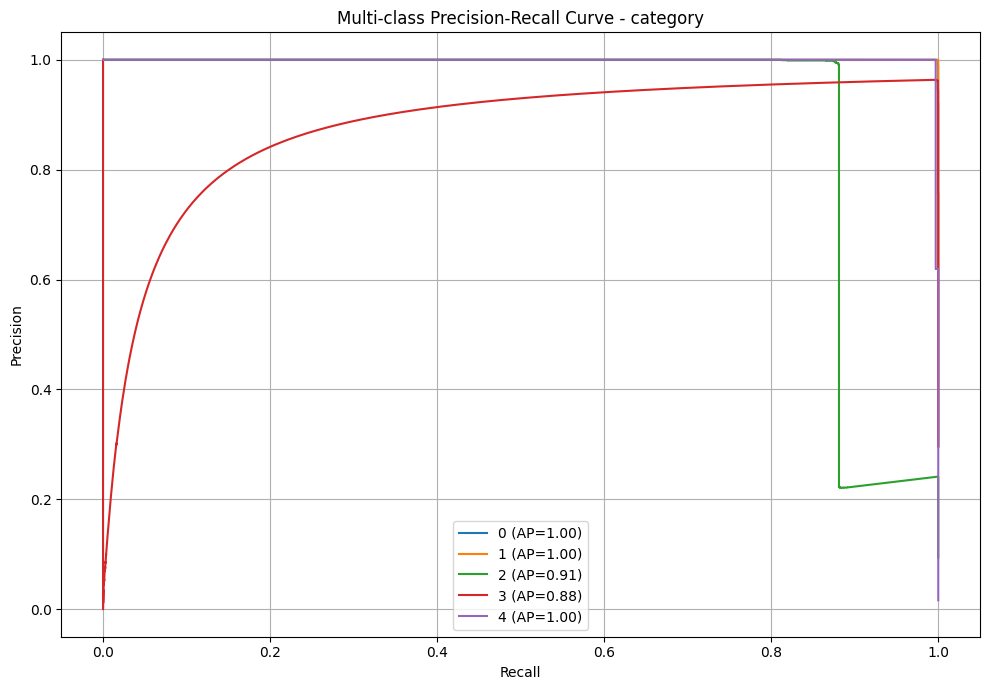

In [137]:
stacked=StackedEnsemble(n_folds=5)

X_cat = np.concatenate([X_train, y_train["attack"].values.reshape(-1, 1)], axis=1)

stacked.fit(X_cat, y_train["category"])


X_cat_test = np.concatenate([X_test, y_pred_attack.reshape(-1, 1)], axis=1)
y_proba = stacked.predict_proba(X_cat_test)

y_pred_category = stacked.predict(X_cat_test)

display_metrics(y_test["category"], y_pred_category, title="category",y_proba=y_proba)


In [138]:
y_score = stacked.predict_proba(X_cat_test)
y_true = np.array(y_test["category"])
classes = [0,1,2,3,4]



In [139]:
stacked=StackedEnsemble(n_folds=5)

X_subcat = np.concatenate([X_cat, y_train["category"].values.reshape(-1, 1)], axis=1)

stacked.fit(X_subcat, y_train["subcategory"])
X_subcat_test = np.concatenate([X_cat_test, y_pred_category.reshape(-1, 1)], axis=1)

y_pred = stacked.predict(X_subcat_test)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:18:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:18:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:19:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:19:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:19:24] WARNING: /w


--- Subcategory ---

📋 Classification Report:
   precision    recall  f1-score  support
0   0.739130  0.708333  0.723404     24.0
1   1.000000  0.888889  0.941176      9.0
2   0.980456  0.980456  0.980456    307.0
3   1.000000  1.000000  1.000000   1910.0
4   0.986371  0.991438  0.988898   1168.0
5   0.997928  0.996689  0.997308   4833.0
6   0.999620  1.000000  0.999810   5265.0
7   1.000000  1.000000  1.000000   6726.0


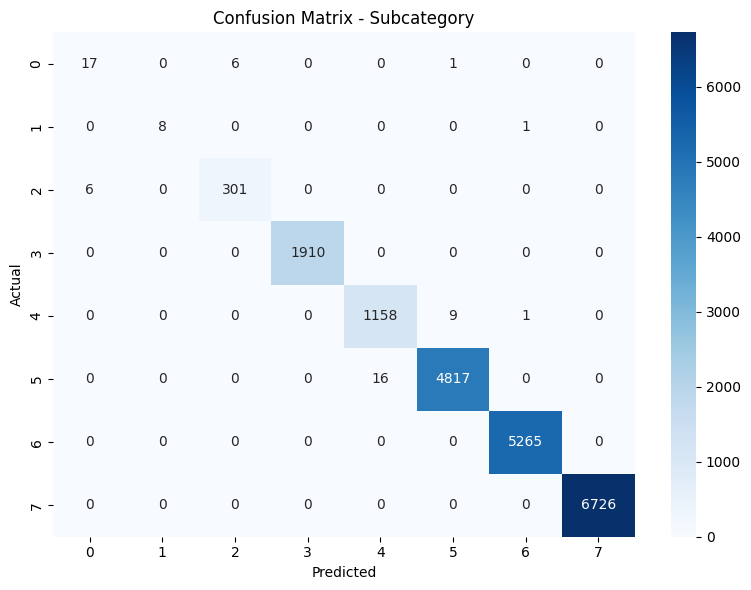


✅ Accuracy: 0.9980
✅ Weighted F1 Score: 0.9980
✅ Macro F1 Score: 0.9539
✅ Macro Precision: 0.9629
✅ Macro Recall: 0.9457
❌ Hamming Loss: 0.001976


In [140]:
display_metrics(y_test["subcategory"], y_pred, title="Subcategory")